In [1]:
from registration_lib import *

In [2]:
# Load the data
help(load_images)
fileStruct = 'testSample_extraHard/ch*.tif'
shape = (50,512,512)

imgs, axID = load_images(fileStruct,shape)

100%|██████████| 2/2 [00:00<00:00, 29.97it/s]

Help on function load_images in module registration_lib:

load_images(fileTemplate, shape)
    Load raw data as nD numpy array.
    
    Args:
        fileTemplate (str): absolute or relative path to rawData.
            The srt should contain one '*' character to identify all the files.
        shape (tuple): expected shape of a single stack.
        
    Returns:
        imgs (nD array): numpy array containing all stacks. By default outputs
            in uint16 type. Dimension is input shape + 1.
        axID (str): axed identification character.

Files detected:  2
Files format: .tif, loading data...
axID:  CZYX
Data shape:  (2, 50, 512, 512)
Data type:  uint16
Data memory (MB):  50.00013732910156




# XY registration

In [3]:
# First, compute the MIP in the Z direction
help(get_mip)

mipZ = get_mip(imgs,axID,'Z',checkMem=True)

Help on function get_mip in module registration_lib:

get_mip(stack, axID, s, checkMem=True)
    Maximum intensioty projection.
    
    Args:
        stack (ndarray): input nd numpy array.
        axID ('str'): axis identifiers of the input array.
        s ('str'): single character identifying the axis over which to compute
            the maximum projection.
        checkMem (bool, optional): check memory of output array. Default:True.
            
    Returns:
        outstack ((n-1)d array): MIP of the input array over the s axis.

Computing maximum projection along Z axis...
Data shape:  (2, 512, 512)
Data type:  uint16
Data memory (MB):  1.0001220703125




100%|██████████| 2/2 [00:00<00:00, 177.89it/s]

Help on function renormalize in module registration_lib:

renormalize(instack, perc=99.7, checkMem=True, visual=False)
    Renormalize input to percentiles and scale to 8bit.
    
    Args:
        instack (nd array): input array. Can be 3d or 4d.
        perc (float, optional): max percentile. Default: 99.7.
        checkMem (bool, optional): check memory of output array. Default:True.
        visual (bool, optional): flag to visualize all channels (or the mip 
               of every channels).
        
    Returns:
        outstack (ndarray): 8bit version of input stack.

Renormalizing to 8bit...
Data shape:  (2, 512, 512)
Data type:  uint8
Data memory (MB):  0.5001220703125




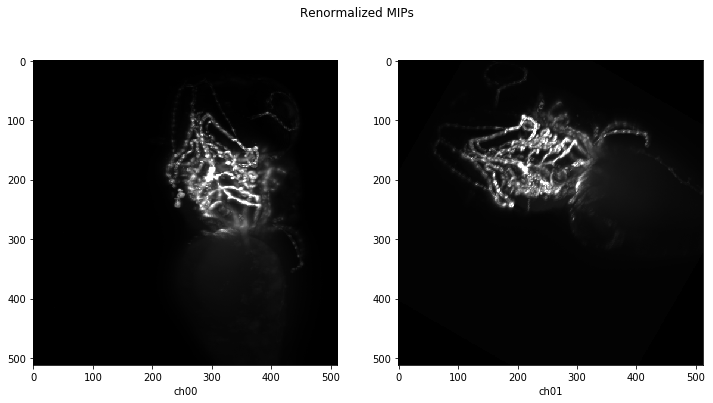

In [4]:
# Next, renormalize the data with percentile and convert to uint8
help(renormalize)

mipZ = renormalize(mipZ, visual=True)

Help on function compute_features in module registration_lib:

compute_features(instack, visual=False)
    Compute SIFT features.
    
    Loops over the first dimension of the input stack and computes all the SIFT
    features. Because SIFT only works on 2D images, the input stack MUST be 3D.
    
    Args:
        instack (3D array): input images.
        visual (bool, optional): flag to visualize features. Default: False.
        
    Returns:
        kp (list): list of keypoints found in every channels.
            NOTE: len(kp) = instack.shape[0].
        desc (list): list of descriptors for every keypoint.
            NOTE: len(desc) = instack.shape[0].

Computing features...


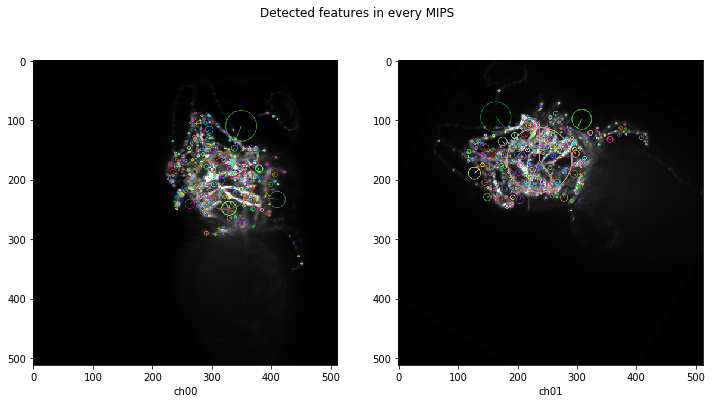

In [5]:
# Compute the features in every channel
help(compute_features)

kps, descs = compute_features(mipZ,visual=True)

Help on function match_features in module registration_lib:

match_features(instack, kps, descs, N=25, visual=False)
    Matching features.
    
    This function matches the features in the first channel to features in 
    every other channel.
    
    Args:
        instack (3D array): input array.
        kps (list): keypoints.
        descs (list): descriptors.
        N (int, optional): number of best features to keep. Default: 25.
        visual (bool, optional): visualize feature matching. default: False
        
    Returns:
        matches (list): features matched.

Matching features...


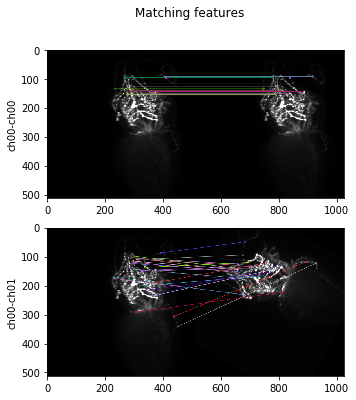

In [6]:
# Match the features
help (match_features)

matches = match_features(mipZ,kps,descs,visual=True)

In [7]:
# Compute image transformation
help(compute_homography)

h = compute_homography(matches,kps)

Help on function compute_homography in module registration_lib:

compute_homography(matches, kps)
    Compute the image transformation to register the corresponding images.
    
    This function always uses the first element of the list as reference.
    I.e. it compute the homography to align channel 1,2... to channel 0.
    
    Args:
        matches (list): matching features.
        kps (list): keypoints in the images.
        
    Returns:
        h (list): every element contains the 3D array that defines the transformation.
                  NOTE: h[0] is always the identity matrix.

Computing Homography...


Help on function XY_register_stacks in module registration_lib:

XY_register_stacks(stacks, h, fileStruct, save=False, visual=False)
    XY registration transformation.
    
    Args:
        stacks (nd array): instup nd array. Can be 3D (mip, axID='CXY') 
                           or 4D (full stack, axID='CZYX'). If 3D, computes the transformation
                           on every channel. If 4D, computes the transformation on single XY planes.
        h (list): homography. List of 3x3 numpy arrays.
        fileStruct (str): input fileStructure. Used in case save=True.
        save (bool, optional): saving images in subfolder. Default: False.
        visual (bool, optional): visualize output. Default: False.
    
    Returns:
        imgsXYreg (ndarray): registered images.

Registering stacks in XY...


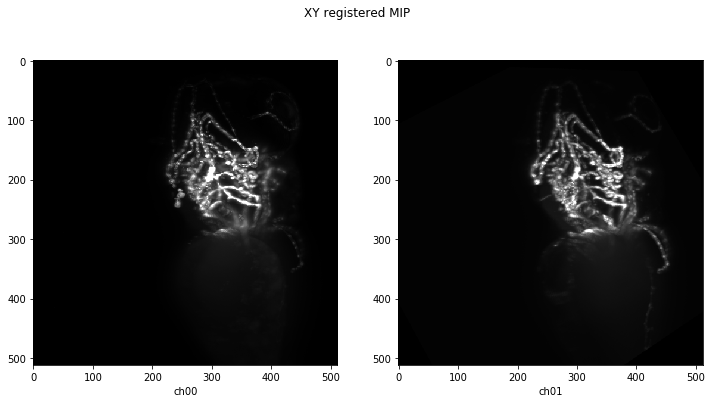

In [8]:
# register MIPs first (optional)
help(XY_register_stacks)

_ = XY_register_stacks(mipZ,h,fileStruct,visual=True)

 28%|██▊       | 14/50 [00:00<00:00, 135.55it/s]

Help on function XY_register_stacks in module registration_lib:

XY_register_stacks(stacks, h, fileStruct, save=False, visual=False)
    XY registration transformation.
    
    Args:
        stacks (nd array): instup nd array. Can be 3D (mip, axID='CXY') 
                           or 4D (full stack, axID='CZYX'). If 3D, computes the transformation
                           on every channel. If 4D, computes the transformation on single XY planes.
        h (list): homography. List of 3x3 numpy arrays.
        fileStruct (str): input fileStructure. Used in case save=True.
        save (bool, optional): saving images in subfolder. Default: False.
        visual (bool, optional): visualize output. Default: False.
    
    Returns:
        imgsXYreg (ndarray): registered images.

Registering stacks in XY...


100%|██████████| 50/50 [00:00<00:00, 170.29it/s]


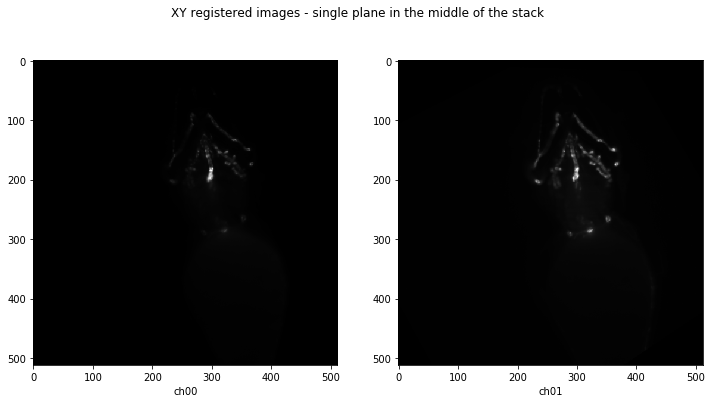

In [9]:
# register full stack
help(XY_register_stacks)

imgsXYreg = XY_register_stacks(imgs,h,fileStruct,visual=True)

# YZ registration

In [10]:
# First, compute the MIP in the X direction
mipX = get_mip(imgsXYreg,axID,'X',checkMem=True)

Computing maximum projection along X axis...
Data shape:  (2, 50, 512)
Data type:  uint16
Data memory (MB):  0.0977783203125




/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 2/2 [00:00<00:00, 796.94it/s]

Renormalizing to 8bit...
Data shape:  (2, 200, 512)
Data type:  uint8
Data memory (MB):  0.1954345703125




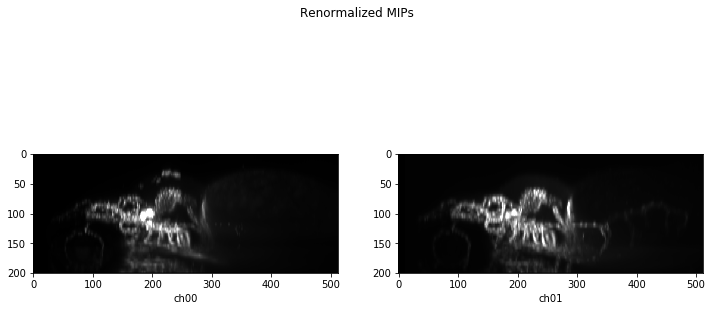

In [11]:
# Next, renormalize the data with percentile and convert to uint8
# NOTE: it's important to upsample in the Z direction to give more pixels to SIFT to compute features on.
Zupsampling = 4
mipX = np.stack([resize_array(m,Zupsampling) for m in mipX])
mipX = renormalize(mipX, visual=True)

Computing features...


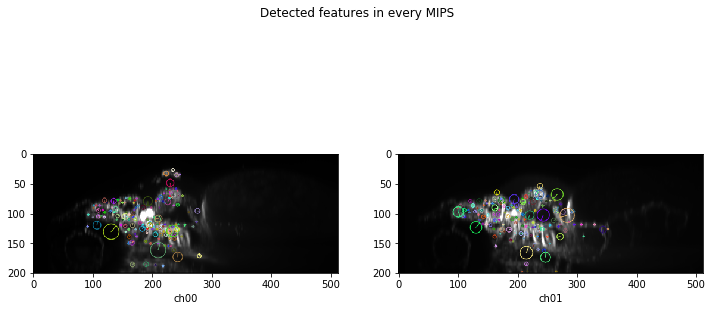

In [12]:
# Compute features
kps,descs = compute_features(mipX,visual=True)

Matching features...


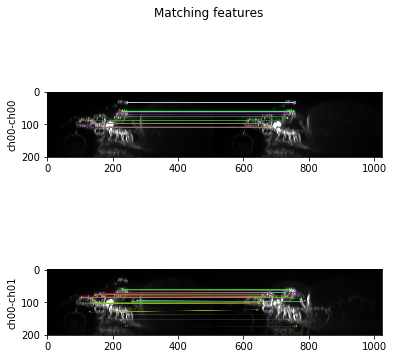

In [13]:
# Match features
matches = match_features(mipX,kps,descs,visual=True)

In [14]:
# Compute image transformation
h = compute_homography(matches,kps)

Computing Homography...


Registering stacks in YZ...


/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


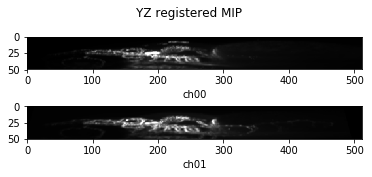

In [15]:
# First, register mips
_ = YZ_register_stacks(mipX[:,::Zupsampling,:],h,fileStruct,upsampling=Zupsampling,save=False,visual=True)

  0%|          | 0/512 [00:00<?, ?it/s]/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  1%|          | 6/512 [00:00<00:09, 52.95it/s]

Registering stacks in YZ...


100%|██████████| 512/512 [00:08<00:00, 61.98it/s]


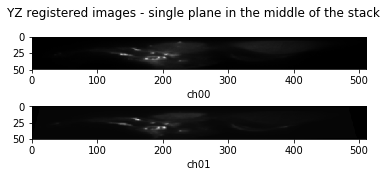

In [17]:
# Compute fully resgistered stack
regStack = YZ_register_stacks(imgsXYreg,h,fileStruct,upsampling=Zupsampling,save=False,visual=True)